In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_mean_std = torchvision.datasets.FashionMNIST('.', train = True, transform = transforms.ToTensor(), download = True)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
# I named this dataset because I will use this to find the mean and std of the pixel values and then using that normalize the actual data
mean = 0.0
std = 0.0
cnt = 0.0

for d in data_mean_std:
    mean += d[0].mean()
    std += d[0].std()
    cnt += 1
    
mean /= cnt
std /= cnt
print(mean, std)

tensor(0.2860) tensor(0.3205)


In [5]:
data_train = torchvision.datasets.FashionMNIST('.', train = True, transform = transforms.Compose([transforms.RandomAffine(degrees = (-20, 20), translate = (0.0, 0.2)),
                                                                                                 transforms.ToTensor(),
                                                                                                 transforms.Normalize(mean = 0.2860, std = 0.3205)]), download = True)
data_test = torchvision.datasets.FashionMNIST('.', train = False, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                 transforms.Normalize(mean = 0.2860, std = 0.3205)]), download = True)

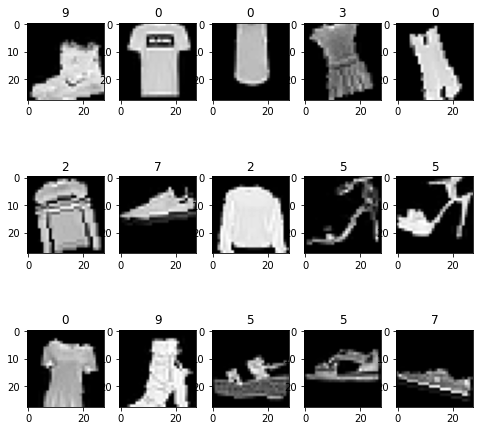

In [7]:
fig = plt.figure(figsize = (8, 8))
for i in range(15):
    img = data_train[i][0].view(28, 28)
    ax = fig.add_subplot(3, 5, i + 1)
    ax.title.set_text(data_train[i][1])
    plt.imshow(img, cmap = "gray")


In [8]:
def make_dataloader(dataset, pct):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    split = int(np.floor(pct * dataset_size))
    train_indices, valid_indices = indices[split:], indices[:split]
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_indices)

    train_loader = DataLoader(dataset, batch_size = 128, sampler = train_sampler)
    valid_loader = DataLoader(dataset, batch_size = 128, sampler = valid_sampler)

    return train_loader, valid_loader

In [9]:
train_loader, valid_loader = make_dataloader(data_train, 0.2)

In [41]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 500).cuda()
        self.relu1 = nn.ReLU().cuda()
        self.linear2 = nn.Linear(500, 200).cuda()
        self.relu2 = nn.ReLU().cuda()
        self.linear3 = nn.Linear(200, 50).cuda()
        self.relu3 = nn.ReLU().cuda()
        self.linear4 = nn.Linear(50, 10).cuda()
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        return x

In [42]:
model = Network()

In [45]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-5)

In [36]:
trainingloss = []
trainingacc = []
validationloss = []
validationacc = []

In [37]:
def accuracy(output, y):
    _, preds = torch.max(output, dim = 1)
    return torch.tensor(torch.sum(preds == y).item() / len(preds))

In [38]:
use_cuda = True
use_cuda, torch.cuda.is_available()

(True, True)

In [46]:
epochs = 10
for e in range(epochs):
    train_acc = torch.tensor(0, dtype = torch.float32)
    train_loss = torch.tensor(0, dtype = torch.float32)
    train_cnt = torch.tensor(0, dtype = torch.float32)

    model.train()
    for (i, batch) in enumerate(train_loader):
        # Unwrap the batch
        X, y = batch
        X, y = Variable(X), Variable(y)
        # Transfer to GPU
        if use_cuda and torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
        
        # Forward pass
        output = model(X)

        # Calculate the loss
        loss = loss_func(output, y)

        # Calculate the gradient of loss wrt the params
        optimizer.zero_grad()
        loss.backward()

        # Subtract the gradients
        optimizer.step()

        # Accumulate the history (NOTE that this is the batch loss and batch accuracy)
        batch_size = X.shape[0]
        train_cnt += batch_size
        acc = accuracy(output, y)
        train_loss += loss * batch_size
        train_acc += acc * batch_size

    train_loss /= train_cnt
    train_acc /= train_cnt
    trainingloss.append(train_loss)
    trainingacc.append(train_acc)

    model.eval()
    with torch.no_grad():
        val_loss = torch.tensor(0, dtype = torch.float32)
        val_acc = torch.tensor(0, dtype = torch.float32)
        val_cnt = torch.tensor(0, dtype = torch.float32)

        for (i, batch) in enumerate(valid_loader):
            # Unwrap the batch
            X, y = batch
            X, y = Variable(X), Variable(y)
            # Transfer to GPU
            if use_cuda and torch.cuda.is_available():
                X = X.cuda()
                y = y.cuda()

            # Forward pass
            output = model(X)
            # Calculate the loss
            loss = loss_func(output, y)
            
            # Accumulate the history
            batch_size = X.shape[0]
            val_cnt += batch_size
            val_loss += loss * batch_size
            acc = accuracy(output, y)
            val_acc += acc * batch_size
        
        val_loss /= val_cnt
        val_acc /= val_cnt
        validationloss.append(val_loss)
        validationacc.append(val_acc)
    print(f"Training Loss - {train_loss : 0.5f} Training Accuracy - {train_acc : 0.5f} Validation Loss - {val_loss : 0.5f} Validation Accuracy - {val_acc : 0.5f}")

Training Loss -  0.41943 Training Accuracy -  0.84310 Validation Loss -  0.42434 Validation Accuracy -  0.84367
Training Loss -  0.40443 Training Accuracy -  0.84825 Validation Loss -  0.41238 Validation Accuracy -  0.84958
Training Loss -  0.40067 Training Accuracy -  0.85046 Validation Loss -  0.41466 Validation Accuracy -  0.84692
Training Loss -  0.39664 Training Accuracy -  0.85052 Validation Loss -  0.41142 Validation Accuracy -  0.84642
Training Loss -  0.39347 Training Accuracy -  0.85156 Validation Loss -  0.41033 Validation Accuracy -  0.84750
Training Loss -  0.39306 Training Accuracy -  0.85265 Validation Loss -  0.40803 Validation Accuracy -  0.84867
Training Loss -  0.39293 Training Accuracy -  0.85196 Validation Loss -  0.40593 Validation Accuracy -  0.84817
Training Loss -  0.38969 Training Accuracy -  0.85202 Validation Loss -  0.40732 Validation Accuracy -  0.84792
Training Loss -  0.39022 Training Accuracy -  0.85321 Validation Loss -  0.40463 Validation Accuracy -  

In [47]:
testloader = DataLoader(data_test, batch_size = 128)

In [55]:
testaccuracy = torch.tensor(0, dtype = torch.float32)
testcnt = torch.tensor(0, dtype = torch.float32)

model.eval()
with torch.no_grad():
    for batch in testloader:
        (X, y) = batch
        X, y = Variable(X), Variable(y)
        if use_cuda and torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
        output = model(X)
        batch_size = X.shape[0]
        testaccuracy += batch_size * accuracy(output, y)
        testcnt += batch_size

testaccuracy /= testcnt
print(f"{testaccuracy : 0.5f}")

 0.85610
